# Image classification on celeb A dataset

In [1]:
!pip install --user pyxlsb


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


**Importing Libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import os
import subprocess
import zipfile
import pandas as pd
import numpy as np
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
import absl.logging
warnings.filterwarnings('ignore', message='You are saving your model as an HDF5 file')
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.applications import VGG16

2025-10-15 19:09:06.080617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760569746.260198 1923433 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760569746.305264 1923433 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760569746.804227 1923433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760569746.804260 1923433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760569746.804262 1923433 computation_placer.cc:177] computation placer alr

**Loading Celeb Data and identity excel sheet**

In [2]:
# Load celebrity metadata
celeb_data = pd.read_excel("list_attr_celeba_with_identity.xlsb", engine='pyxlsb')
celeb_data = celeb_data.dropna(subset=['image_id', 'Celeb_identity'])
celeb_data['Celeb_identity'] = celeb_data['Celeb_identity'].astype(int)

In [3]:
print(f"Dataset: {len(celeb_data)} samples, {celeb_data['Celeb_identity'].nunique()} identities")

Dataset: 202599 samples, 10177 identities


In [4]:
base_dir = './celeba_dataset'
img_dir = None
for path in [f"{base_dir}/img_align_celeba/img_align_celeba", 
             f"{base_dir}/img_align_celeba", base_dir]:
    if Path(path).exists():
        img_dir = path
        break

In [5]:
# Prepare paths and encode labels
img_paths = [str(Path(img_dir) / img) for img in celeb_data['image_id']]
encoder = LabelEncoder()
labels = encoder.fit_transform(celeb_data['Celeb_identity'])
n_classes = len(encoder.classes_)


In [6]:
# Image preprocessing function
@tf.function
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0
    # Add augmentation for training
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    return img, label

In [7]:
# Create datasets
dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
dataset = dataset.shuffle(10000, seed=42)

I0000 00:00:1760570000.732337 1923433 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


In [8]:
split = int(0.8 * len(img_paths))
train_ds = dataset.take(split).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(split).map(lambda x,y: (preprocess(x,y)[0], y)).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
print(f"Train: {split} samples, Val: {len(img_paths)-split} samples")

Train: 162079 samples, Val: 40520 samples


## Training for top celebrities with decent amount of images

In [10]:
print("STEP 1: LOADING AND FILTERING CELEBRITY DATA")
print("=" * 50)
identity_file = "./identity_CelebA.xlsx"
df_identity = pd.read_excel(identity_file)

print(f"Original dataset shape: {df_identity.shape}")
print(f"Total images: {len(df_identity)}")
print(f"Total unique celebrities: {df_identity.iloc[:, 1].nunique()}")
celebrity_counts = df_identity.iloc[:, 1].value_counts()

print(f"\nCelebrity distribution:")
print(f"Min images per celebrity: {celebrity_counts.min()}")
print(f"Max images per celebrity: {celebrity_counts.max()}")
print(f"Mean images per celebrity: {celebrity_counts.mean():.1f}")

celebrities_with_2plus = celebrity_counts[celebrity_counts >= 2]
print(f"\nCelebrities with 2+ images: {len(celebrities_with_2plus)}")

valid_celebrities = celebrities_with_2plus.index.tolist()
df_filtered = df_identity[df_identity.iloc[:, 1].isin(valid_celebrities)].copy()

print(f"Filtered dataset:")
print(f"Images: {len(df_filtered)}")
print(f"Celebrities (classes): {len(valid_celebrities)}")

celebrity_to_label = {celeb_id: idx for idx, celeb_id in enumerate(valid_celebrities)}
df_filtered['celebrity_label'] = df_filtered.iloc[:, 1].map(celebrity_to_label)
df_filtered.columns = ['image_filename', 'celebrity_id', 'celebrity_label']

print(f"\nSample data:")
print(df_filtered.head())

print(f"\nClass distribution (first 10 classes):")
class_counts = df_filtered['celebrity_label'].value_counts().sort_index()
for i in range(min(10, len(class_counts))):
    celeb_id = valid_celebrities[i]
    count = class_counts[i]
    print(f"Class {i} (Celebrity {celeb_id}): {count} images")

print(f"\n Step 1 Complete!")
print(f"Ready for training with {len(valid_celebrities)} celebrity classes")

STEP 1: LOADING AND FILTERING CELEBRITY DATA
Original dataset shape: (202599, 2)
Total images: 202599
Total unique celebrities: 10177

Celebrity distribution:
Min images per celebrity: 1
Max images per celebrity: 35
Mean images per celebrity: 19.9

Celebrities with 2+ images: 10133
Filtered dataset:
Images: 202555
Celebrities (classes): 10133

Sample data:
  image_filename  celebrity_id  celebrity_label
0     000001.jpg          2880               32
1     000002.jpg          2937             1171
2     000003.jpg          8692             2096
3     000004.jpg          5805             2102
4     000005.jpg          9295             3541

Class distribution (first 10 classes):
Class 0 (Celebrity 3227): 35 images
Class 1 (Celebrity 2820): 35 images
Class 2 (Celebrity 3782): 35 images
Class 3 (Celebrity 3745): 34 images
Class 4 (Celebrity 3699): 34 images
Class 5 (Celebrity 9152): 32 images
Class 6 (Celebrity 8968): 32 images
Class 7 (Celebrity 9256): 32 images
Class 8 (Celebrity 4887):

# CREATING MANAGEABLE SUBSET FOR TRAINING-change here for trying 1000

In [11]:
print("STEP 2: CREATING MANAGEABLE SUBSET FOR TRAINING")
print("=" * 50)

N_CELEBRITIES = 100

print(f"Selecting top {N_CELEBRITIES} celebrities with most images...")
celebrity_counts = df_filtered['celebrity_id'].value_counts()
top_celebrities = celebrity_counts.head(N_CELEBRITIES).index.tolist()

print(f"Top {N_CELEBRITIES} celebrities image counts:")
print(f"Max: {celebrity_counts.iloc[0]} images")
print(f"Min: {celebrity_counts.iloc[N_CELEBRITIES-1]} images")

# ✅ REQUIRED CELEBRITY IDS (must be included even if not in top 100)
required_ids = [
    4126, 7904, 8656, 9319, 3321, 8968, 2820, 3227, 9063, 8871, 7282, 8945,
    3782, 8722, 3401, 1964, 4561, 2880, 3745, 3699, 9152, 9256, 2463, 2562,
    3431, 1499, 8045, 10173, 2522, 228, 5239, 2425, 4304, 5260, 2837, 1158,
    3698, 6098, 6568, 9151, 800, 619, 487, 1852, 8265, 447, 1757
]

# Combine top 100 + required IDs
all_selected_ids = sorted(set(top_celebrities) | set(required_ids))

print(f"\nTotal unique celebrities after inclusion: {len(all_selected_ids)}")

# Filter dataset to include all selected IDs
df_subset = df_filtered[df_filtered['celebrity_id'].isin(all_selected_ids)].copy()

# Map each celebrity ID to a label
celebrity_to_label = {celeb_id: idx for idx, celeb_id in enumerate(all_selected_ids)}
df_subset['celebrity_label'] = df_subset['celebrity_id'].map(celebrity_to_label)

print(f"\nSubset dataset:")
print(f"Images: {len(df_subset)}")
print(f"Classes: {len(all_selected_ids)}")
print(f"Average images per class: {len(df_subset)/len(all_selected_ids):.1f}")

class_dist = df_subset['celebrity_label'].value_counts()
print(f"\nClass distribution stats:")
print(f"Min images per class: {class_dist.min()}")
print(f"Max images per class: {class_dist.max()}")

df_subset.to_csv('./celebrity_subset.csv', index=False)
print(f"\nSaved subset to: celebrity_subset.csv")

print(f"\nSample of subset data:")
print(df_subset.head(10))

print(f"\nStep 2 Complete!")
print(f"Ready to proceed with {len(all_selected_ids)} classes and {len(df_subset)} images")

NUM_CLASSES = len(all_selected_ids)
TOTAL_IMAGES = len(df_subset)

print(f"\nFor next steps:")
print(f"NUM_CLASSES = {NUM_CLASSES}")
print(f"TOTAL_IMAGES = {TOTAL_IMAGES}")

STEP 2: CREATING MANAGEABLE SUBSET FOR TRAINING
Selecting top 100 celebrities with most images...
Top 100 celebrities image counts:
Max: 35 images
Min: 30 images

Total unique celebrities after inclusion: 134

Subset dataset:
Images: 3952
Classes: 134
Average images per class: 29.5

Class distribution stats:
Min images per class: 10
Max images per class: 35

Saved subset to: celebrity_subset.csv

Sample of subset data:
    image_filename  celebrity_id  celebrity_label
0       000001.jpg          2880               32
42      000043.jpg          5239               61
61      000062.jpg          1499               13
95      000096.jpg          4262               44
115     000116.jpg          4887               53
134     000135.jpg          2522               28
149     000150.jpg          6568               83
154     000155.jpg           800                4
167     000168.jpg          2463               27
237     000238.jpg          4561               49

Step 2 Complete!
Ready to 

# Augmentation

In [12]:
print("\nSTEP 2.5: AUGMENTING IMAGES (10x per image)")
print("=" * 50)

from PIL import ImageEnhance, ImageOps
from tqdm import tqdm

# Configuration
OUTPUT_IMG_DIR = "./augmented_celebrity_images"
OUTPUT_CSV = './celebrity_augmented.csv'
AUGMENTATIONS_PER_IMAGE = 10

# Create output directory
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
print(f"Created directory: {OUTPUT_IMG_DIR}")

def augment_image(img, aug_type):
    """Apply augmentation while keeping celebrity identity"""
    img = img.copy()
    
    if aug_type == 0:
        return img  # Original
    elif aug_type == 1:
        return ImageOps.mirror(img)  # Horizontal flip
    elif aug_type == 2:
        angle = np.random.uniform(-15, 15)
        return img.rotate(angle, fillcolor=(0, 0, 0))  # Rotation
    elif aug_type == 3:
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(np.random.uniform(0.7, 1.3))  # Brightness
    elif aug_type == 4:
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(np.random.uniform(0.8, 1.2))  # Contrast
    elif aug_type == 5:
        # Zoom (crop and resize)
        width, height = img.size
        crop_percent = np.random.uniform(0.85, 0.95)
        new_width = int(width * crop_percent)
        new_height = int(height * crop_percent)
        left = np.random.randint(0, width - new_width)
        top = np.random.randint(0, height - new_height)
        cropped = img.crop((left, top, left + new_width, top + new_height))
        return cropped.resize((width, height), Image.LANCZOS)
    elif aug_type == 6:
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(np.random.uniform(0.8, 1.2))  # Saturation
    elif aug_type == 7:
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(np.random.uniform(0.8, 1.2))  # Sharpness
    elif aug_type == 8:
        img = ImageOps.mirror(img)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(np.random.uniform(0.8, 1.2))  # Flip + Brightness
    elif aug_type == 9:
        angle = np.random.uniform(-10, 10)
        img = img.rotate(angle, fillcolor=(0, 0, 0))
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(np.random.uniform(0.9, 1.1))  # Rotation + Contrast
    return img

# Augment images
augmented_data = []
IMG_DIR = "./celeba_dataset/img_align_celeba/img_align_celeba"

print(f"\nAugmenting {len(df_subset)} images (creating {len(df_subset) * AUGMENTATIONS_PER_IMAGE} total)...")

for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Processing"):
    original_filename = row['image_filename']
    celebrity_id = row['celebrity_id']
    celebrity_label = row['celebrity_label']
    
    img_path = os.path.join(IMG_DIR, original_filename)
    
    try:
        img = Image.open(img_path).convert('RGB')
        
        # Create 10 augmented versions
        for aug_idx in range(AUGMENTATIONS_PER_IMAGE):
            aug_img = augment_image(img, aug_idx)
            
            # Save with new filename
            base_name = os.path.splitext(original_filename)[0]
            new_filename = f"{base_name}_aug{aug_idx}.jpg"
            new_path = os.path.join(OUTPUT_IMG_DIR, new_filename)
            aug_img.save(new_path, quality=95)
            
            # Keep celebrity_id and celebrity_label intact
            augmented_data.append({
                'image_filename': new_filename,
                'celebrity_id': celebrity_id,
                'celebrity_label': celebrity_label
            })
    except Exception as e:
        print(f"Error with {img_path}: {e}")

# Create new dataframe with augmented images
df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Augmentation Complete!")
print(f"Original: {len(df_subset)} images")
print(f"Augmented: {len(df_augmented)} images")
print(f"Images per class: {len(df_augmented) // NUM_CLASSES}")
print(f"\nSaved to: {OUTPUT_CSV}")
print(f"Images in: {OUTPUT_IMG_DIR}/")


STEP 2.5: AUGMENTING IMAGES (10x per image)
Created directory: ./augmented_celebrity_images

Augmenting 3952 images (creating 39520 total)...


Processing: 100%|██████████| 3952/3952 [05:23<00:00, 12.21it/s]



✅ Augmentation Complete!
Original: 3952 images
Augmented: 39520 images
Images per class: 294

Saved to: ./celebrity_augmented.csv
Images in: ./augmented_celebrity_images/


STEP 3: LOADING AND PREPROCESSING IMAGES
Loading 39520 images...
Target image size: (64, 64)
Image directory: ./augmented_celebrity_images
Processed 0/39520 images...
Processed 500/39520 images...
Processed 1000/39520 images...
Processed 1500/39520 images...
Processed 2000/39520 images...
Processed 2500/39520 images...
Processed 3000/39520 images...
Processed 3500/39520 images...
Processed 4000/39520 images...
Processed 4500/39520 images...
Processed 5000/39520 images...
Processed 5500/39520 images...
Processed 6000/39520 images...
Processed 6500/39520 images...
Processed 7000/39520 images...
Processed 7500/39520 images...
Processed 8000/39520 images...
Processed 8500/39520 images...
Processed 9000/39520 images...
Processed 9500/39520 images...
Processed 10000/39520 images...
Processed 10500/39520 images...
Processed 11000/39520 images...
Processed 11500/39520 images...
Processed 12000/39520 images...
Processed 12500/39520 images...
Processed 13000/39520 images...
Processed 13500/39520

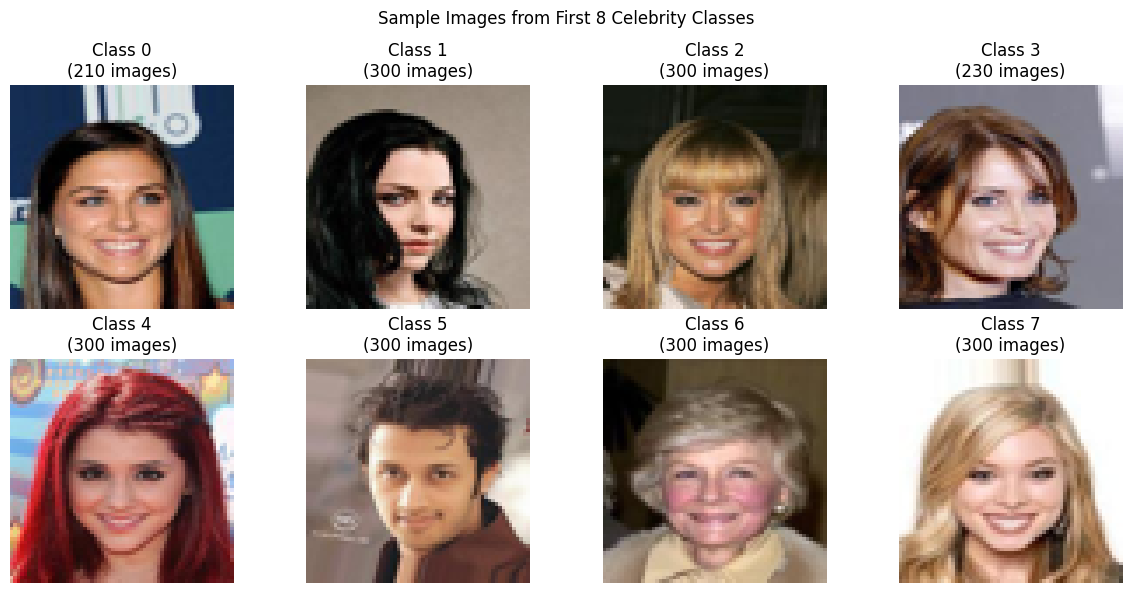


Class distribution in loaded data:
Number of classes: 134
Min images per class: 100
Max images per class: 350
Mean images per class: 294.9

✅ Step 3 Complete!
Ready for train/validation/test split!

For next steps:
X.shape = (39520, 64, 64, 3)
y.shape = (39520,)
NUM_CLASSES = 134


In [13]:
print("STEP 3: LOADING AND PREPROCESSING IMAGES")
print("=" * 50)

# CHANGE THESE 2 LINES:
df_subset = pd.read_csv('./celebrity_augmented.csv')  # Changed from celebrity_subset.csv
IMG_DIR = "./augmented_celebrity_images"  # Changed from original path

IMG_SIZE = (64, 64) 

print(f"Loading {len(df_subset)} images...")
print(f"Target image size: {IMG_SIZE}")
print(f"Image directory: {IMG_DIR}")

images = []
labels = []
failed_loads = 0

for idx, row in df_subset.iterrows():
    if idx % 500 == 0:
        print(f"Processed {idx}/{len(df_subset)} images...")
    
    img_path = os.path.join(IMG_DIR, row['image_filename'])
    
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(IMG_SIZE)
            img_array = np.array(img) / 255.0
            
            images.append(img_array)
            labels.append(row['celebrity_label'])
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            failed_loads += 1
    else:
        print(f"File not found: {img_path}")
        failed_loads += 1

X = np.array(images)
y = np.array(labels)

print(f"\nImage loading complete!")
print(f"Successfully loaded: {len(X)} images")
print(f"Failed loads: {failed_loads}")
print(f"Image array shape: {X.shape}")
print(f"Labels array shape: {y.shape}")
print(f"Image data type: {X.dtype}")
print(f"Pixel value range: {X.min():.3f} to {X.max():.3f}")

print(f"\nDisplaying sample images from different celebrities...")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

sample_classes = np.unique(y)[:8]  # First 8 classes
for i, class_id in enumerate(sample_classes):
    class_indices = np.where(y == class_id)[0]
    if len(class_indices) > 0:
        img_idx = class_indices[0]
        
        axes[i].imshow(X[img_idx])
        axes[i].set_title(f'Class {class_id}\n({len(class_indices)} images)')
        axes[i].axis('off')

plt.suptitle('Sample Images from First 8 Celebrity Classes')
plt.tight_layout()
plt.show()

unique_labels, counts = np.unique(y, return_counts=True)
print(f"\nClass distribution in loaded data:")
print(f"Number of classes: {len(unique_labels)}")
print(f"Min images per class: {counts.min()}")
print(f"Max images per class: {counts.max()}")
print(f"Mean images per class: {counts.mean():.1f}")

print(f"\n✅ Step 3 Complete!")
print(f"Ready for train/validation/test split!")
print(f"\nFor next steps:")
print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")
print(f"NUM_CLASSES = {len(unique_labels)}")

# Splitting the data

In [14]:
print("STEP 4: TRAIN/VALIDATION/TEST SPLIT")
print("=" * 50)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"Original dataset: {X.shape[0]} images, {len(np.unique(y))} classes")

# Shuffle the data
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Split: 70% train, 15% validation, 15% test
# First split: 85% temp (train+val), 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_shuffled, y_shuffled, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_shuffled  # Ensures balanced classes
)

# Second split: 70% train, 15% val (from temp)
# 15/85 = 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nData split:")
print(f"Training set:   {X_train.shape[0]} images ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} images ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Check classes in each split
train_classes = len(np.unique(y_train))
val_classes = len(np.unique(y_val))
test_classes = len(np.unique(y_test))

print(f"\nClasses in each split:")
print(f"Training:   {train_classes} classes")
print(f"Validation: {val_classes} classes") 
print(f"Test:       {test_classes} classes")

# Check class distribution
def check_class_distribution(y_split, split_name):
    unique, counts = np.unique(y_split, return_counts=True)
    print(f"\n{split_name} class distribution:")
    print(f"  Min images per class: {counts.min()}")
    print(f"  Max images per class: {counts.max()}")
    print(f"  Mean images per class: {counts.mean():.1f}")

check_class_distribution(y_train, "Training")
check_class_distribution(y_val, "Validation") 
check_class_distribution(y_test, "Test")

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, num_classes=len(np.unique(y)))
y_val_categorical = to_categorical(y_val, num_classes=len(np.unique(y)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y)))

print(f"\nCategorical labels shape:")
print(f"y_train_categorical: {y_train_categorical.shape}")
print(f"y_val_categorical: {y_val_categorical.shape}")
print(f"y_test_categorical: {y_test_categorical.shape}")

# Verify data integrity
print(f"\nData integrity check:")
print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Image pixel range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"All classes represented: {len(np.unique(y_train)) == len(np.unique(y))}")

NUM_CLASSES = len(np.unique(y))
INPUT_SHAPE = X_train.shape[1:]  

print(f"\n✅ Step 4 Complete!")
print(f"Data is ready for CNN training!")
print(f"\nFor model building:")
print(f"INPUT_SHAPE = {INPUT_SHAPE}")
print(f"NUM_CLASSES = {NUM_CLASSES}")
print(f"Training samples: {X_train.shape[0]}")

STEP 4: TRAIN/VALIDATION/TEST SPLIT
Original dataset: 39520 images, 134 classes

Data split:
Training set:   27679 images (70.0%)
Validation set: 5913 images (15.0%)
Test set:       5928 images (15.0%)

Classes in each split:
Training:   134 classes
Validation: 134 classes
Test:       134 classes

Training class distribution:
  Min images per class: 70
  Max images per class: 246
  Mean images per class: 206.6

Validation class distribution:
  Min images per class: 15
  Max images per class: 52
  Mean images per class: 44.1

Test class distribution:
  Min images per class: 15
  Max images per class: 53
  Mean images per class: 44.2

Categorical labels shape:
y_train_categorical: (27679, 134)
y_val_categorical: (5913, 134)
y_test_categorical: (5928, 134)

Data integrity check:
Training images shape: (27679, 64, 64, 3)
Training labels shape: (27679, 134)
Image pixel range: [0.000, 1.000]
All classes represented: True

✅ Step 4 Complete!
Data is ready for CNN training!

For model building

# Model Definition

In [15]:
print("STEP 5: DEFINING ALL MODELS")
print("=" * 50)

from tensorflow.keras import layers, models
import tensorflow as tf

# Storage for results and trained models
MODEL_RESULTS = {}
TRAINED_MODELS = {}

def create_cnn_model():
    """Create a custom CNN model for celebrity classification"""
    
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


def create_vgg16_model():
    """VGG16 pre-trained model for celebrity classification"""
    from tensorflow.keras.applications import VGG16
    
    # Load pre-trained VGG16 (without top layers)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = models.Sequential([
        # Resize input to 128x128 for VGG16
        layers.Lambda(lambda x: tf.image.resize(x, [128, 128])),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


def create_deep_residual_cnn():
    """Deep CNN with residual connections (ResNet-style)"""
    
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # Initial convolution
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual Block 1
    shortcut = x
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Residual Block 2
    shortcut = layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual Block 3
    shortcut = layers.Conv2D(256, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    # Residual Block 4
    shortcut = layers.Conv2D(512, (1, 1), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model


print("\n✅ All model definitions loaded!")
print("\nAvailable models:")
print("1. create_cnn_model() - Custom CNN")
print("2. create_vgg16_model() - Transfer Learning (VGG16)")
print("3. create_deep_residual_cnn() - Deep ResNet-style CNN")

STEP 5: DEFINING ALL MODELS

✅ All model definitions loaded!

Available models:
1. create_cnn_model() - Custom CNN
2. create_vgg16_model() - Transfer Learning (VGG16)
3. create_deep_residual_cnn() - Deep ResNet-style CNN


In [16]:
print("STEP 6: SETTING UP TRAINING FUNCTION")
print("=" * 50)

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

def train_and_evaluate_model(model_name, create_func, epochs=30, batch_size=32, learning_rate=0.001):
    """Train and evaluate a single model"""
    
    print(f"\n{'='*60}")
    print(f"TRAINING: {model_name}")
    print(f"{'='*60}")
    
    # Create model
    model = create_func()
    
    # Build model with input shape
    model.build(input_shape=(None,) + INPUT_SHAPE) 
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Display model info
    print(f"Model parameters: {model.count_params():,}")
    
    # Setup callbacks
    callbacks_list = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model
    print(f"Starting training...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train_categorical,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val_categorical),
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
    
    # Store results
    results = {
        'model_name': model_name,
        'model': model,
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'training_time': training_time,
        'total_parameters': model.count_params()
    }
    
    MODEL_RESULTS[model_name] = results
    TRAINED_MODELS[model_name] = model
    
    print(f"\n{model_name} RESULTS:")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
    print(f"Best Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"Training Time: {training_time/60:.1f} minutes")
    
    return results

print("\n✅ Training function ready!")
print("\nFeatures:")
print("  • Early stopping (patience=10)")
print("  • Learning rate reduction (patience=5)")
print("  • Model checkpointing (saves best model)")
print("  • Automatic evaluation on test set")
print("  • Results stored in MODEL_RESULTS and TRAINED_MODELS")

STEP 6: SETTING UP TRAINING FUNCTION

✅ Training function ready!

Features:
  • Early stopping (patience=10)
  • Learning rate reduction (patience=5)
  • Model checkpointing (saves best model)
  • Automatic evaluation on test set
  • Results stored in MODEL_RESULTS and TRAINED_MODELS


# Training Starts

# Traditional CNN 

In [17]:
print("\n" + "="*60)
print("TRAINING MODEL 1/3: CNN MODEL")
print("="*60)

# Train CNN Model
train_and_evaluate_model(
    model_name='CNN_Model',
    create_func=create_cnn_model,
    epochs=25,
    batch_size=32,
    learning_rate=0.001
)

print("\n✅ CNN Model training complete!")
print(f"Test Accuracy: {MODEL_RESULTS['CNN_Model']['test_accuracy']*100:.2f}%")


TRAINING MODEL 1/3: CNN MODEL

TRAINING: CNN_Model


/opt/miniconda/envs/eai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model parameters: 1,504,806
Starting training...
Epoch 1/25


I0000 00:00:1760570732.924713 1923666 service.cc:152] XLA service 0x14cec801aa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760570732.924740 1923666 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-10-15 19:25:33.069644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760570733.747937 1923666 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-15 19:25:35.030605: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,64,64]{3,2,1,0} %bitcast.17605, f32[32,3,3,3]{3,2,1,0} %bitcast.17612, f32[32]{0} %bitcast.18901), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

 19/865 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0062 - loss: 6.1102

I0000 00:00:1760570740.470461 1923666 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


862/865 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0282 - loss: 5.0911

2025-10-15 19:25:48.809944: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[31,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,3,64,64]{3,2,1,0} %bitcast.17605, f32[32,3,3,3]{3,2,1,0} %bitcast.17612, f32[32]{0} %bitcast.18901), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:25:48.819256: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy 

865/865 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0282 - loss: 5.0893

2025-10-15 19:25:54.591813: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[32,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,64,64]{3,2,1,0} %bitcast.810, f32[32,3,3,3]{3,2,1,0} %bitcast.817, f32[32]{0} %bitcast.819), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:25:54.607148: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algori


Epoch 1: val_accuracy improved from -inf to 0.19313, saving model to CNN_Model_best.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.0283 - loss: 5.0887 - val_accuracy: 0.1931 - val_loss: 3.4497 - learning_rate: 0.0010
Epoch 2/25
863/865 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1725 - loss: 3.4425
Epoch 2: val_accuracy improved from 0.19313 to 0.41553, saving model to CNN_Model_best.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1726 - loss: 3.4417 - val_accuracy: 0.4155 - val_loss: 2.2753 - learning_rate: 0.0010
Epoch 3/25
862/865 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3303 - loss: 2.6185
Epoch 3: val_accuracy improved from 0.41553 to 0.61238, saving model to CNN_Model_best.keras
865/865 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3304 - loss: 2.6178 - val_accuracy: 0.6124 - val_loss: 1.5618 - learning_rate: 0.0010
Epoch 4/25
862/865 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4471 - loss: 2.0731
Epoch 4: val_accuracy improved from 0.61

2025-10-15 19:29:05.821886: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.18 = (f32[8,32,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,64,64]{3,2,1,0} %bitcast.810, f32[32,3,3,3]{3,2,1,0} %bitcast.817, f32[32]{0} %bitcast.819), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:29:05.853051: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorith


CNN_Model RESULTS:
Test Accuracy: 0.9646 (96.5%)
Best Val Accuracy: 0.9670
Training Time: 3.6 minutes

✅ CNN Model training complete!
Test Accuracy: 96.46%


# VGG16

In [18]:
print("\n" + "="*60)
print("TRAINING MODEL 2/3: VGG16 TRANSFER LEARNING")
print("="*60)

# Train VGG16 Transfer Learning Model
train_and_evaluate_model(
    model_name='VGG16_Transfer',
    create_func=create_vgg16_model,
    epochs=10,
    batch_size=16,
    learning_rate=0.001
)

print("\n✅ VGG16 Model training complete!")
print(f"Test Accuracy: {MODEL_RESULTS['VGG16_Transfer']['test_accuracy']*100:.2f}%")


TRAINING MODEL 2/3: VGG16 TRANSFER LEARNING

TRAINING: VGG16_Transfer
Model parameters: 15,145,158
Starting training...
Epoch 1/10


2025-10-15 19:30:01.368480: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[16,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,128,128]{3,2,1,0} %bitcast.6947, f32[64,3,3,3]{3,2,1,0} %bitcast.6954, f32[64]{0} %bitcast.6956), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:30:01.415782: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

1729/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1223 - loss: 4.1265

2025-10-15 19:30:31.550613: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[15,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,128,128]{3,2,1,0} %bitcast.6945, f32[64,3,3,3]{3,2,1,0} %bitcast.6952, f32[64]{0} %bitcast.6954), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:30:31.580567: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1224 - loss: 4.1261

2025-10-15 19:30:41.504725: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[9,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,3,128,128]{3,2,1,0} %bitcast.1144, f32[64,3,3,3]{3,2,1,0} %bitcast.1151, f32[64]{0} %bitcast.1153), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:30:41.579147: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549]


Epoch 1: val_accuracy improved from -inf to 0.45611, saving model to VGG16_Transfer_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.1224 - loss: 4.1258 - val_accuracy: 0.4561 - val_loss: 2.2023 - learning_rate: 0.0010
Epoch 2/10
1729/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3423 - loss: 2.6106
Epoch 2: val_accuracy improved from 0.45611 to 0.56300, saving model to VGG16_Transfer_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.3423 - loss: 2.6105 - val_accuracy: 0.5630 - val_loss: 1.6918 - learning_rate: 0.0010
Epoch 3/10
1728/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4294 - loss: 2.1996
Epoch 3: val_accuracy improved from 0.56300 to 0.65381, saving model to VGG16_Transfer_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.4294 - loss: 2.1995 - val_accuracy: 0.6538 - val_loss: 1.3590 - learning_rate: 0.0010
Epoch 4/10
1729/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4748 - loss: 1.9733
Epoch 

2025-10-15 19:35:31.867215: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.1144, f32[64,3,3,3]{3,2,1,0} %bitcast.1151, f32[64]{0} %bitcast.1153), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/vgg16_1/block1_conv1_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:35:31.976679: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54


VGG16_Transfer RESULTS:
Test Accuracy: 0.8193 (81.9%)
Best Val Accuracy: 0.8263
Training Time: 5.6 minutes

✅ VGG16 Model training complete!
Test Accuracy: 81.93%


# Deep Residual CNN

In [19]:
print("\n" + "="*60)
print("TRAINING MODEL 3/3: DEEP RESIDUAL CNN")
print("="*60)

# Train Deep Residual CNN Model
train_and_evaluate_model(
    model_name='Deep_Residual_CNN',
    create_func=create_deep_residual_cnn,
    epochs=12,
    batch_size=16,
    learning_rate=0.0005
)

print("\n✅ Deep Residual CNN training complete!")
print(f"Test Accuracy: {MODEL_RESULTS['Deep_Residual_CNN']['test_accuracy']*100:.2f}%")


TRAINING MODEL 3/3: DEEP RESIDUAL CNN

TRAINING: Deep_Residual_CNN
Model parameters: 6,033,798
Starting training...
Epoch 1/12


2025-10-15 19:36:11.129394: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.51 = (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,16,16]{3,2,1,0} %bitcast.26843, f32[64,64,3,3]{3,2,1,0} %bitcast.24511, f32[64]{0} %bitcast.26903), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:36:11.198787: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

1726/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0107 - loss: 5.8918

2025-10-15 19:36:37.838378: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.51 = (f32[15,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,16,16]{3,2,1,0} %bitcast.26843, f32[64,64,3,3]{3,2,1,0} %bitcast.24511, f32[64]{0} %bitcast.26903), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:36:37.895035: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0108 - loss: 5.8905

2025-10-15 19:36:45.819516: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.47 = (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,16,16]{3,2,1,0} %bitcast.1345, f32[64,64,3,3]{3,2,1,0} %bitcast.1352, f32[64]{0} %bitcast.1354), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:36:48.147774: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot


Epoch 1: val_accuracy improved from -inf to 0.04042, saving model to Deep_Residual_CNN_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - accuracy: 0.0108 - loss: 5.8901 - val_accuracy: 0.0404 - val_loss: 4.4847 - learning_rate: 5.0000e-04
Epoch 2/12
1726/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0378 - loss: 4.5147
Epoch 2: val_accuracy improved from 0.04042 to 0.08693, saving model to Deep_Residual_CNN_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.0379 - loss: 4.5142 - val_accuracy: 0.0869 - val_loss: 3.8381 - learning_rate: 5.0000e-04
Epoch 3/12
1726/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0913 - loss: 3.8920
Epoch 3: val_accuracy improved from 0.08693 to 0.19110, saving model to Deep_Residual_CNN_best.keras
1730/1730 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.0913 - loss: 3.8917 - val_accuracy: 0.1911 - val_loss: 3.2434 - learning_rate: 5.0000e-04
Epoch 4/12
1726/1730 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1555 

2025-10-15 19:40:22.092429: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.47 = (f32[32,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,16,16]{3,2,1,0} %bitcast.1345, f32[64,64,3,3]{3,2,1,0} %bitcast.1352, f32[64]{0} %bitcast.1354), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_3_1/conv2d_7_1/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:40:22.134431: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot


Deep_Residual_CNN RESULTS:
Test Accuracy: 0.8342 (83.4%)
Best Val Accuracy: 0.8287
Training Time: 4.3 minutes

✅ Deep Residual CNN training complete!
Test Accuracy: 83.42%



FINAL COMPARISON: ALL MODELS

Model                     Test Accuracy   Val Accuracy    Parameters      Time (min)     
-------------------------------------------------------------------------------------
CNN_Model                 96.46          % 96.70          % 1,504,806       3.6            
VGG16_Transfer            81.93          % 82.63          % 15,145,158      5.6            
Deep_Residual_CNN         83.42          % 82.87          % 6,033,798       4.3            

🏆 BEST MODEL: CNN_Model
   Test Accuracy: 96.46%
   Saved as 'best_model' variable


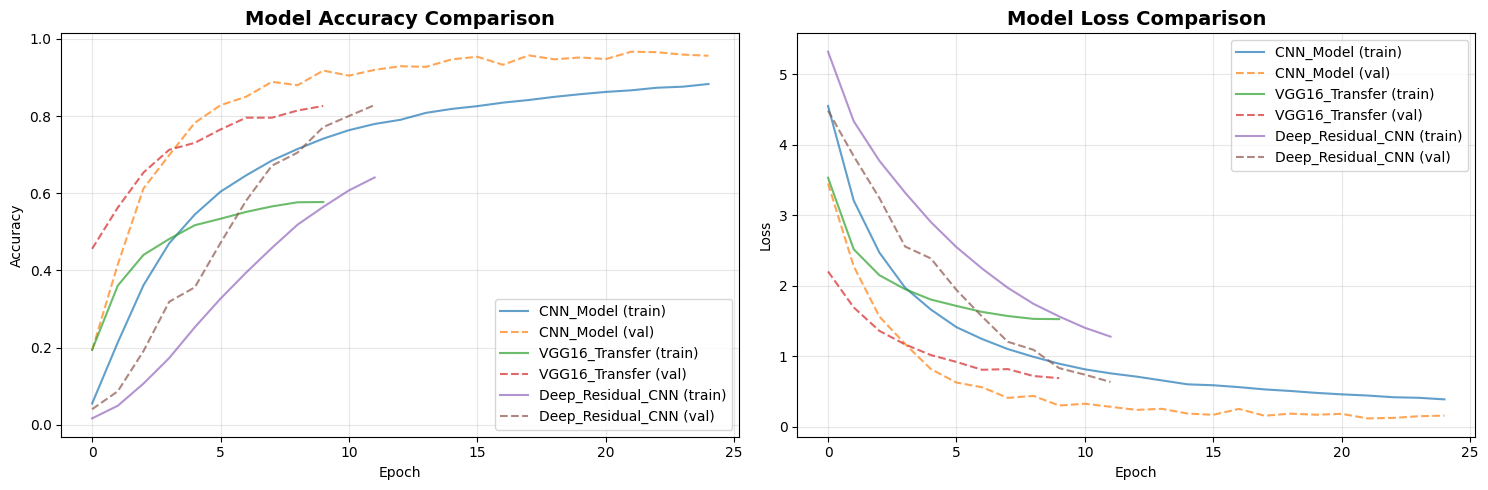


✅ All models trained and compared!


In [20]:
print("\n" + "="*70)
print("FINAL COMPARISON: ALL MODELS")
print("="*70)

if len(MODEL_RESULTS) == 0:
    print("⚠️ No models trained yet! Train models first.")
else:
    # Create comparison table
    print("\n{:<25} {:<15} {:<15} {:<15} {:<15}".format(
        "Model", "Test Accuracy", "Val Accuracy", "Parameters", "Time (min)"
    ))
    print("-" * 85)
    
    for name, results in MODEL_RESULTS.items():
        print("{:<25} {:<15.2f}% {:<15.2f}% {:<15,} {:<15.1f}".format(
            results['model_name'],
            results['test_accuracy'] * 100,
            results['best_val_accuracy'] * 100,
            results['total_parameters'],
            results['training_time'] / 60
        ))
    
    # Find best model
    best_model_name = max(MODEL_RESULTS, key=lambda x: MODEL_RESULTS[x]['test_accuracy'])
    best_model = TRAINED_MODELS[best_model_name]  # Store best model for later use
    best_acc = MODEL_RESULTS[best_model_name]['test_accuracy'] * 100
    
    print("\n" + "="*70)
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"   Test Accuracy: {best_acc:.2f}%")
    print(f"   Saved as 'best_model' variable")
    print("="*70)
    
    # Plot training curves for all models
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for name, results in MODEL_RESULTS.items():
        history = results['history']
        
        # Plot accuracy
        axes[0].plot(history.history['accuracy'], label=f'{name} (train)', alpha=0.7)
        axes[0].plot(history.history['val_accuracy'], label=f'{name} (val)', linestyle='--', alpha=0.7)
        
        # Plot loss
        axes[1].plot(history.history['loss'], label=f'{name} (train)', alpha=0.7)
        axes[1].plot(history.history['val_loss'], label=f'{name} (val)', linestyle='--', alpha=0.7)
    
    axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Model Loss Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ All models trained and compared!")

In [22]:
print("="*70)
print("SAVING BEST MODEL + MAPPINGS FOR REUSE")
print("="*70)

import json  # ← ADD THIS LINE!

if len(MODEL_RESULTS) == 0:
    print("❌ ERROR: No models trained yet!")
else:
    # Find best model
    best_model_name = max(MODEL_RESULTS, key=lambda x: MODEL_RESULTS[x]['test_accuracy'])
    best_model = TRAINED_MODELS[best_model_name]
    best_accuracy = MODEL_RESULTS[best_model_name]['test_accuracy']
    
    print(f"🏆 Best Model: {best_model_name} ({best_accuracy*100:.2f}%)")
    
    # Save model
    MODEL_SAVE_PATH = 'celebrity_detector_best.keras'
    best_model.save(MODEL_SAVE_PATH)
    print(f"✅ Model saved: {MODEL_SAVE_PATH}")
    
    # IMPORTANT: Save celebrity ID mapping
    # Get unique celebrity IDs and their corresponding labels
    unique_labels = sorted(df_subset['celebrity_label'].unique())
    label_to_celebrity = {}
    
    for label in unique_labels:
        celeb_id = df_subset[df_subset['celebrity_label'] == label]['celebrity_id'].iloc[0]
        label_to_celebrity[int(label)] = int(celeb_id)
    
    # Save comprehensive metadata
    metadata = {
        'model_name': best_model_name,
        'test_accuracy': float(best_accuracy),
        'input_shape': [64, 64, 3],  # Actual image size used
        'num_classes': NUM_CLASSES,
        'label_to_celebrity_id': label_to_celebrity,  # CRITICAL for prediction
        'training_info': {
            name: {
                'test_accuracy': float(results['test_accuracy']),
                'parameters': int(results['total_parameters'])
            }
            for name, results in MODEL_RESULTS.items()
        }
    }
    
    with open('celebrity_detector_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)
    
    print(f"✅ Metadata saved: celebrity_detector_metadata.json")
    print(f"\n📦 Files for new notebook:")
    print(f"   1. {MODEL_SAVE_PATH}")
    print(f"   2. celebrity_detector_metadata.json")
    print(f"\n✅ Ready for prediction in new notebook!")

SAVING BEST MODEL + MAPPINGS FOR REUSE
🏆 Best Model: CNN_Model (96.46%)
✅ Model saved: celebrity_detector_best.keras
✅ Metadata saved: celebrity_detector_metadata.json

📦 Files for new notebook:
   1. celebrity_detector_best.keras
   2. celebrity_detector_metadata.json

✅ Ready for prediction in new notebook!


# Testing with training datset (Works)

STEP 8: SINGLE IMAGE PREDICTION FUNCTION
Loaded mapping for 134 classes
Sample mapping: Class 0 -> Celebrity ID 228

Testing single image celebrity prediction...


2025-10-15 19:44:08.938823: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[1,32,60,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,62,62]{3,2,1,0} %bitcast.535, f32[32,32,3,3]{3,2,1,0} %bitcast.542, f32[32]{0} %bitcast.544), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/opt/miniconda/envs/eai/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-10-15 19:44:08.964136: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algo


Correct Prediction - Test Image 1
Image: 000001_aug0.jpg
Ground Truth - Celebrity ID: 2880 | Class: 32


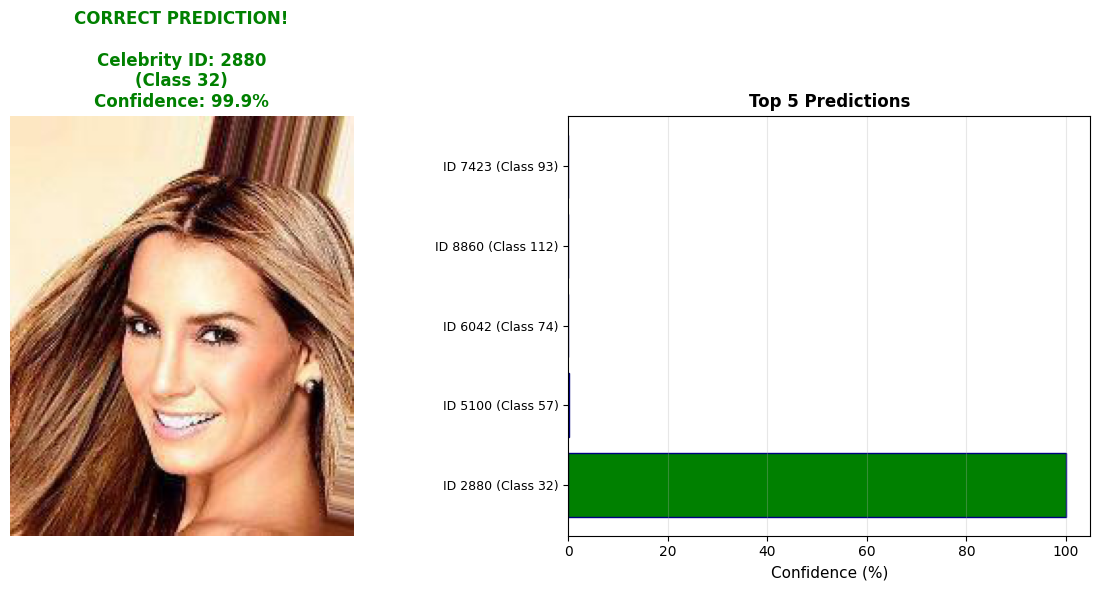


Prediction for: 000001_aug0.jpg
Celebrity ID: 2880
PREDICTION: CORRECT!
> 1. Celebrity ID:  2880 | Class:  32 | Confidence:  99.90%
  2. Celebrity ID:  5100 | Class:  57 | Confidence:   0.09%
  3. Celebrity ID:  6042 | Class:  74 | Confidence:   0.00%
  4. Celebrity ID:  8860 | Class: 112 | Confidence:   0.00%
  5. Celebrity ID:  7423 | Class:  93 | Confidence:   0.00%

Correct Prediction - Test Image 2
Image: 000135_aug0.jpg
Ground Truth - Celebrity ID: 2522 | Class: 28


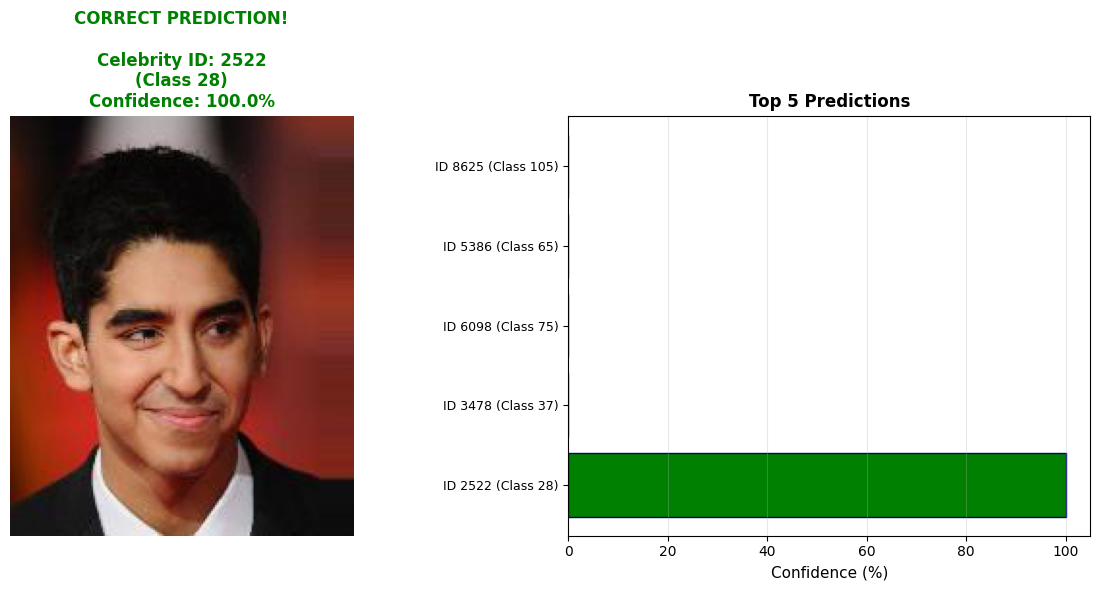


Prediction for: 000135_aug0.jpg
Celebrity ID: 2522
PREDICTION: CORRECT!
> 1. Celebrity ID:  2522 | Class:  28 | Confidence:  99.96%
  2. Celebrity ID:  3478 | Class:  37 | Confidence:   0.04%
  3. Celebrity ID:  6098 | Class:  75 | Confidence:   0.00%
  4. Celebrity ID:  5386 | Class:  65 | Confidence:   0.00%
  5. Celebrity ID:  8625 | Class: 105 | Confidence:   0.00%

Correct Prediction - Test Image 3
Image: 000294_aug0.jpg
Ground Truth - Celebrity ID: 2522 | Class: 28


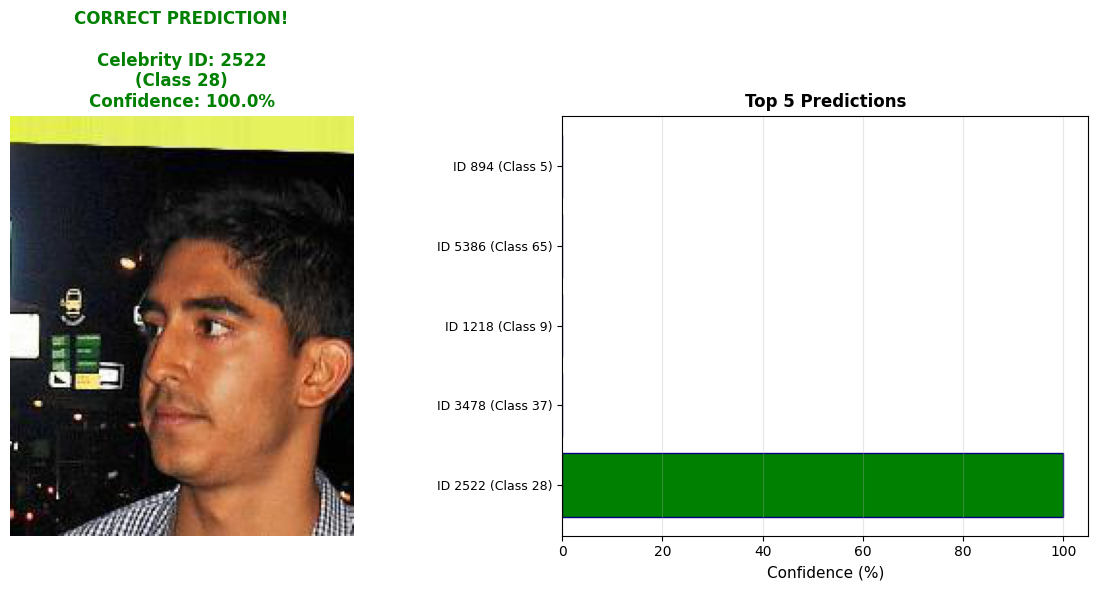


Prediction for: 000294_aug0.jpg
Celebrity ID: 2522
PREDICTION: CORRECT!
> 1. Celebrity ID:  2522 | Class:  28 | Confidence: 100.00%
  2. Celebrity ID:  3478 | Class:  37 | Confidence:   0.00%
  3. Celebrity ID:  1218 | Class:   9 | Confidence:   0.00%
  4. Celebrity ID:  5386 | Class:  65 | Confidence:   0.00%
  5. Celebrity ID:   894 | Class:   5 | Confidence:   0.00%

PREDICTION SUMMARY
Total Predictions Tested: 3
Correct Predictions Shown: 3
Accuracy: 100.0%


In [23]:

print("STEP 8: SINGLE IMAGE PREDICTION FUNCTION")
print("=" * 50)

label_to_celeb_id = df_subset.groupby('celebrity_label')['celebrity_id'].first().to_dict()

print(f"Loaded mapping for {len(label_to_celeb_id)} classes")
print(f"Sample mapping: Class 0 -> Celebrity ID {label_to_celeb_id[0]}")

def predict_celebrity_image(image_path, model, top_k=5):
    
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        predictions = model.predict(img_array, verbose=0)[0]
        
        top_indices = np.argsort(predictions)[-top_k:][::-1]
        
        results = {
            'image_path': image_path,
            'top_predictions': []
        }
        
        for i, idx in enumerate(top_indices):
            confidence = predictions[idx] * 100
            celebrity_id = label_to_celeb_id.get(int(idx), -1)
            results['top_predictions'].append({
                'rank': i + 1,
                'celebrity_class': int(idx),
                'celebrity_id': celebrity_id,
                'confidence': confidence
            })
        
        return results
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def display_prediction_with_image(image_path, results, actual_celeb_id):
    
    if results is None:
        return
    
    predicted_celeb_id = results['top_predictions'][0]['celebrity_id']
    is_correct = (predicted_celeb_id == actual_celeb_id)
    
    if not is_correct:
        return
    
    plt.figure(figsize=(12, 6))
    
    img = Image.open(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    top_pred = results['top_predictions'][0]
    
    title = f'CORRECT PREDICTION!\n\nCelebrity ID: {top_pred["celebrity_id"]}\n(Class {top_pred["celebrity_class"]})\nConfidence: {top_pred["confidence"]:.1f}%'
    plt.title(title, fontsize=12, fontweight='bold', color='green')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    labels = [f'ID {p["celebrity_id"]} (Class {p["celebrity_class"]})' for p in results['top_predictions']]
    confidences = [p['confidence'] for p in results['top_predictions']]
    
    colors = ['green' if p['celebrity_id'] == actual_celeb_id else 'skyblue' for p in results['top_predictions']]
    
    plt.barh(range(len(labels)), confidences, color=colors, edgecolor='navy')
    plt.yticks(range(len(labels)), labels, fontsize=9)
    plt.xlabel('Confidence (%)', fontsize=11)
    plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction for: {os.path.basename(image_path)}")
    print("=" * 80)
    print(f"Celebrity ID: {actual_celeb_id}")
    print("PREDICTION: CORRECT!")
    print("=" * 80)
    
    for pred in results['top_predictions']:
        marker = ">" if pred['celebrity_id'] == actual_celeb_id else " "
        print(f"{marker} {pred['rank']}. Celebrity ID: {pred['celebrity_id']:5d} | "
              f"Class: {pred['celebrity_class']:3d} | "
              f"Confidence: {pred['confidence']:6.2f}%")
    print("=" * 80)

model = best_model

print("\nTesting single image celebrity prediction...")
sample_indices = [0, 50, 100]

correct_predictions = 0
total_predictions = 0

for i, idx in enumerate(sample_indices):
    if idx < len(df_subset):
        sample_image_path = os.path.join(IMG_DIR, df_subset.iloc[idx]['image_filename'])
        actual_celeb_id = df_subset.iloc[idx]['celebrity_id']
        actual_class = df_subset.iloc[idx]['celebrity_label']
        
        if os.path.exists(sample_image_path):
            results = predict_celebrity_image(sample_image_path, model)
            if results:
                predicted_celeb_id = results['top_predictions'][0]['celebrity_id']
                
                if predicted_celeb_id == actual_celeb_id:
                    print(f"\n{'='*80}")
                    print(f"Correct Prediction - Test Image {i+1}")
                    print(f"Image: {df_subset.iloc[idx]['image_filename']}")
                    print(f"Ground Truth - Celebrity ID: {actual_celeb_id} | Class: {actual_class}")
                    print('='*80)
                    
                    display_prediction_with_image(sample_image_path, results, actual_celeb_id)
                    correct_predictions += 1
                
                total_predictions += 1

print(f"\n{'='*80}")
print(f"PREDICTION SUMMARY")
print(f"{'='*80}")
print(f"Total Predictions Tested: {total_predictions}")
print(f"Correct Predictions Shown: {correct_predictions}")
if total_predictions > 0:
    accuracy = (correct_predictions/total_predictions)*100
    print(f"Accuracy: {accuracy:.1f}%")
print(f"{'='*80}")




# Training with Unseen data (works)

In [1]:
print("PREDICT CELEBRITY FROM YOUR IMAGE")
print("=" * 60)

# ============================================
# CHANGE THIS: Put your image path here
# ============================================
image_path = "./006515.jpg"  # Example path
# ============================================

# Optional: Provide actual celebrity ID if you know it (for verification)
actual_celeb_id = None  # Set to None if unknown, or provide the ID

print(f"Image to predict: {image_path}")

if not os.path.exists(image_path):
    print(f"❌ ERROR: Image not found at {image_path}")
    print("\nPlease check:")
    print("1. File path is correct")
    print("2. File exists in that location")
else:
    # Make prediction
    print(f"\n🔍 Making prediction...")
    results = predict_celebrity_image(image_path, best_model, top_k=5)
    
    if results:
        # Display image with predictions
        plt.figure(figsize=(14, 6))
        
        # Show image
        img = Image.open(image_path)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        
        top_pred = results['top_predictions'][0]
        title = f'Top Prediction\n\nCelebrity ID: {top_pred["celebrity_id"]}\nClass: {top_pred["celebrity_class"]}\nConfidence: {top_pred["confidence"]:.1f}%'
        
        if actual_celeb_id is not None:
            is_correct = (top_pred["celebrity_id"] == actual_celeb_id)
            color = 'green' if is_correct else 'red'
            status = 'CORRECT ✓' if is_correct else 'INCORRECT ✗'
            title += f'\n\n{status}'
        else:
            color = 'blue'
            
        plt.title(title, fontsize=12, fontweight='bold', color=color)
        
        # Show confidence bars
        plt.subplot(1, 2, 2)
        labels = [f'ID {p["celebrity_id"]}\n(Class {p["celebrity_class"]})' for p in results['top_predictions']]
        confidences = [p['confidence'] for p in results['top_predictions']]
        
        colors = ['green' if actual_celeb_id and p['celebrity_id'] == actual_celeb_id else 'skyblue' 
                  for p in results['top_predictions']]
        
        bars = plt.barh(range(len(labels)), confidences, color=colors, edgecolor='navy')
        plt.yticks(range(len(labels)), labels, fontsize=10)
        plt.xlabel('Confidence (%)', fontsize=11)
        plt.title('Top 5 Predictions', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.xlim(0, 100)
        
        # Add percentage labels on bars
        for i, (bar, conf) in enumerate(zip(bars, confidences)):
            plt.text(conf + 1, i, f'{conf:.1f}%', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print("\n" + "=" * 80)
        print("PREDICTION RESULTS")
        print("=" * 80)
        print(f"Image: {os.path.basename(image_path)}")
        
        if actual_celeb_id is not None:
            print(f"Actual Celebrity ID: {actual_celeb_id}")
            if top_pred["celebrity_id"] == actual_celeb_id:
                print("Status: ✓ CORRECT PREDICTION!")
            else:
                print(f"Status: ✗ INCORRECT (Predicted: {top_pred['celebrity_id']})")
        
        print("\nTop 5 Predictions:")
        print("-" * 80)
        
        for pred in results['top_predictions']:
            marker = "→" if pred['rank'] == 1 else " "
            check = "✓" if actual_celeb_id and pred['celebrity_id'] == actual_celeb_id else " "
            
            print(f"{check} {marker} Rank {pred['rank']}: "
                  f"Celebrity ID {pred['celebrity_id']:5d} | "
                  f"Class {pred['celebrity_class']:3d} | "
                  f"Confidence: {pred['confidence']:6.2f}%")
        
        print("=" * 80)
    else:
        print(" Prediction failed!")

print("\n To predict another image:")
print("   1. Change the 'image_path' variable above")
print("   2. Run this cell again")

PREDICT CELEBRITY FROM YOUR IMAGE
Image to predict: ./006515.jpg


NameError: name 'os' is not defined

# FULL DATASET TRAINING 

# Build custom CNN model

In [ ]:
# Build CNN model
def create_model(n_classes):
    return tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(48, 3, padding='same', activation='relu', input_shape=(128,128,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 2  
        tf.keras.layers.Conv2D(96, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 3
        tf.keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        # Block 4
        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAvgPool2D(),
        
        # Dense layers
        tf.keras.layers.Dense(640, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(320, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])

In [ ]:
# Create and compile model
model = create_model(n_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model params: {model.count_params():,}")

In [ ]:
# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=5, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Trying to train the model with complete dataset

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)

print(f"Best val accuracy: {max(history.history['val_accuracy']):.4f}")

The main problem with the CelebA dataset is that it has over 10,000 different celebrities, but the photos are distributed very unfairly - some celebrities have hundreds of photos while most have only 1 or 2 photos. This makes it extremely hard for the model to learn because to recognize someone's face properly, you need many different photos of them (at least 50-100) showing different angles, lighting, and expressions. When you only have 2 photos of someone, the model can't really learn what makes their face unique, it just memorizes those exact 2 photos. The model ends up being good at recognizing celebrities it has seen many times but completely fails on the thousands of celebrities with very few photos.